In [ ]:
import gym
import torch
from gym import spaces
import random
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
'''
"I (We) certify that the code and data in this assignment were generated independently,
using only the tools and resources defined in the course and that I (we) did not receive
any external help, coaching or contributions during the production of this work."
'''

# Part 1

In [ ]:
'''
import gym 

env=gym.make("CartPole-v1")

env.reset()

for i in range(200):
    env.render()
    env.step(env.action_space.sample())
    
env.close()

mountain_car=gym.make("MountainCar-v0")
mountain_car.reset()

for i in range(500):
    mountain_car.render()
    mountain_car.step(mountain_car.action_space.sample())

mountain_car.close()
'''

In [ ]:

class GridEnvironment(gym.Env):

    def __init__(self, gamma, epsilon, epsilonDecay, alpha, episodes = 20, maxTimesteps = 12, rows = 4, cols = 4, stochastic = False):
        #grid should be square for generalization
        self.eventRecord = []
        self.rows = rows
        self.cols = cols
        self.observation_space = spaces.Discrete(self.rows*self.cols)
        self.actions = {"UP":0, "RIGHT":1, "DOWN":2,"LEFT":3}
        self.maxTimesteps = maxTimesteps
        self.state = np.zeros((self.rows, self.cols))
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [self.rows-1, self.cols-1]
        self.trap_pos = [1,1]
        self.bonus_pos = [0,3]
        self.state = np.zeros((self.rows, self.cols))
        self.reward = {tuple(self.goal_pos): 2, tuple(self.trap_pos) : -1, tuple(self.bonus_pos): 1}
        self.rewardStates = {tuple(self.goal_pos), tuple(self.trap_pos), tuple(self.bonus_pos)}
        self.state[tuple(self.agent_pos)] = 2
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.trap_pos)] = 1
        self.state[tuple(self.bonus_pos)] = 1.5
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilonDecay = epsilonDecay
        self.alpha = alpha
        self.episodes = episodes
        self.maxTimesteps = maxTimesteps
        self.stochastic = stochastic
        self.cumulativeReward = 0
        self.done = False
        #q-table
        self.qTable = dict()
        for i in range(self.rows):
            for j in range(self.cols):
                self.qTable[tuple([i,j])] = [0,0,0,0]
    
    def reset(self):
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [self.rows-1, self.cols-1]
        self.trap_pos = [1,1]
        self.bonus_pos = [0,3]
        self.state = np.zeros((self.rows, self.cols))
        self.state = np.zeros((self.rows, self.cols))
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.trap_pos)] = 1
        self.state[tuple(self.bonus_pos)] = 1.5
        self.state[tuple(self.agent_pos)] = 2
        self.cumulativeReward = 0
        self.eventRecord = []
        observation = self.state.flatten()
        return observation
    
    def render(self):
        plt.imshow(self.state)
    
    def step(self, action):
    #adding stochasticity using random function
        sign = 1
        if self.stochastic:
            if np.random.random(1)[0] < 0.2:
                sign  = -1
        if action == 0:
            self.agent_pos[0] -= sign*1
        elif action == 1:
            self.agent_pos[1] += sign*1
        elif action == 2:
            self.agent_pos[0] += sign*1
        elif action == 3:
            self.agent_pos[1] -= sign*1

        if self.agent_pos[0]<0:
            self.agent_pos[0] = 0
        elif self.agent_pos[1] < 0:
            self.agent_pos[1] = 0
        elif self.agent_pos[0] >= self.rows:
            self.agent_pos[0] = self.rows-1
        elif self.agent_pos[1] >= self.cols:
            self.agent_pos[1] = self.cols-1
        #print("agent: ", self.agent_pos)
        #self.agent_pos = np.clip(self.agent_pos, 0, self.rows-1)
        self.eventRecord.append([self.agent_pos, action, self.getReward(self.agent_pos)])

        self.state = np.zeros((self.rows, self.cols))
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.trap_pos)] = 1
        self.state[tuple(self.bonus_pos)] = 1.5
        self.state[tuple(self.agent_pos)] = 2
        observation = self.state.flatten()
        self.timestep += 1
        done = True if self.timestep >= self.maxTimesteps else False
        self.cumulativeReward+=self.getReward(self.agent_pos)
        d = {}

        return np.asarray(observation), np.asarray(self.cumulativeReward), np.asarray(done)

    def getValidActions(self):
        actionAvailable = self.possibleAction(self.agent_pos)
        stateAvailable = self.getAllFinalPosition(actionAvailable)
        finalaction, finalstate = self.getStateActionPair(actionAvailable, stateAvailable)
        return finalaction

    def possibleAction(self, pos):
        possibleAction = [0,1,2,3]
        if pos[1]==0:
            possibleAction.remove(3)
        if pos[1]==self.cols-1:
            possibleAction.remove(1)
        if pos[0]==0:
            possibleAction.remove(0)
        if pos[0]==self.rows-1:
            possibleAction.remove(2)
        if pos[0]==self.rows-1 and pos[1]==self.cols-1:
            self.done = True
        return possibleAction

    def getAllFinalPosition(self, allAvailableActions):
        positionPossible = []
        for i in allAvailableActions:
            positionPossible.append(self.getFinalPosAfterAction(i))
        return positionPossible

    def getFinalPosAfterAction(self, action):
        nextState = self.agent_pos.copy()
        if action == 0:
            nextState[0] -=1
        elif action == 1:
            nextState[1] +=1
        elif action == 2:
            nextState[0] +=1
        elif action == 3:
            nextState[1] -=1

        if nextState[0]<0:
            nextState[0] = 0
        elif nextState[1]<0:
            nextState[1] = 0
        elif nextState[0]>=self.rows:
            nextState[0] = self.rows-1
        elif nextState[1]>=self.cols:
            nextState[1] = self.cols-1

        return nextState

    def getReward(self,pos):
        if tuple(pos) not in self.rewardStates:
            return -0.2
        else:
            return self.reward[tuple(pos)]

    def getStateActionPair(self, possibleAction, possibleStates):
        action = -1
        state = [-1,-1]
        #Random Epsilon
        if np.random.uniform(0,1) <= self.epsilon:
            action, state, _, _ = self.bestStateFromQValue(possibleAction, possibleStates)
            remainingActions, remainingStates = [], []
            for i in possibleAction:
                if i!=action:
                    remainingActions.append(i)
            for i in possibleStates:
                if not (i[0]==state[0] and i[1]==state[1]):
                    remainingStates.append(i)
            action = random.choice(remainingActions)
            state = remainingStates[remainingActions.index(action)]
        #Greedy
        else:
            action, state, _, _ = self.bestStateFromQValue(possibleAction, possibleStates)
        return action, state

    def bestStateFromQValue(self,possibleActions, possibleStates):
        currentMax = None
        fstate = None
        faction = None
        qValues = None

        for action,state in zip(possibleActions, possibleStates):
            if state[0] == self.rows-1 or state[1] == self.cols-1:
                return action, state,0, 0 

            elif currentMax == None:
                currentMax= self.qTable[tuple(self.agent_pos)][action]
                fstate = state
                faction = action
                qValues = self.qTable[tuple(self.agent_pos)]

            elif currentMax != None:
                max1 = self.qTable[tuple(self.agent_pos)][action]
                if max1 > currentMax:
                    currentMax = max1
                    fstate = state
                    faction = action
                    qValues = self.qTable[tuple(self.agent_pos)]

        return faction, fstate, currentMax, qValues

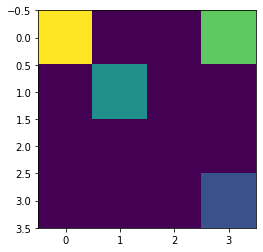

In [ ]:
env = GridEnvironment(0.9,0.8,0.8,0.1)
observation=env.reset()
env.render()

In [159]:

class DQN():

    def __init__(self, env):
        self.env = env
        self.create_model=self.create_model()
        

    def create_model(self):

        model=torch.nn.Sequential(
            torch.nn.Linear(4,2),
            torch.nn.ReLU(),
            torch.nn.Linear(2,1)
        )

        loss=torch.nn.MSELoss()
        optimizer=torch.optim.Adam(model.parameters(),lr=0.01)



    def update_Q(self,state,action,reward,next_state,done):
        Q_current=self.model()
        Q_next=self.model()

        Q_current.eval()
        Q_next.eval()

        Q_current=Q_current(torch.tensor(state,dtype=torch.float32))
        Q_next=Q_next(torch.tensor(next_state,dtype=torch.float32))

        Q_target=Q_current.clone()

        if not done:
            Q_target[0,action]=reward+self.gamma*torch.max(Q_next)
        else:
            Q_target[0,action]=reward

        loss=self.loss(Q_target,Q_current)
        self.loss.append(loss.item())

        Q_current.train()
        Q_next.train()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self):

        for i in range(self.epochs):
            state=self.env.reset()
            done=False
            while not done:
                action=self.get_action(state)
                next_state,reward,done,_=self.env.step(action)
                self.update_Q(state,action,reward,next_state,done)
                state=next_state
